This notebook describes exploritory data analysis and ETL pipeline building steps for natural language processing project. The notebook is a part of Data Science nanodegree project. The data is provided by <a href='https://appen.com/'>Figure Eight (aquired by Appen)</a> and the objective of the project is to build a web app that will correctly classify disaster messages for a better and quicker response.

First step is to import libraries, load the data and analyse it before building ETL pipeline.

In [4]:
# libraries imports
import warnings
warnings.filterwarnings('ignore')
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet
nltk.download(['punkt','wordnet','stopwords','averaged_perceptron_tagger'])
from gensim.models import Phrases
from collections import Counter

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HurazovRuslan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HurazovRuslan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HurazovRuslan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\HurazovRuslan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [5]:
# read the data
messages = pd.read_csv('messages.csv')
classes = pd.read_csv('categories.csv')

In [6]:
# datasets' general info
messages.head()

,id,message,original,genre
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct


In [7]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26248 entries, 0 to 26247
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        26248 non-null  int64 
 1   message   26248 non-null  object
 2   original  10184 non-null  object
 3   genre     26248 non-null  object
dtypes: int64(1), object(3)
memory usage: 820.4+ KB


In [8]:
classes.head()

,id,categories
0,2,related-1;request-0;offer-0;aid_related-0;medi...
1,7,related-1;request-0;offer-0;aid_related-1;medi...
2,8,related-1;request-0;offer-0;aid_related-0;medi...
3,9,related-1;request-1;offer-0;aid_related-1;medi...
4,12,related-1;request-0;offer-0;aid_related-0;medi...


In [9]:
classes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26248 entries, 0 to 26247
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          26248 non-null  int64 
 1   categories  26248 non-null  object
dtypes: int64(1), object(1)
memory usage: 410.2+ KB


So, here is what we have so far:
- 4 columns and 26248 rows in messages dataset (id, message, original and genre). Original column has a lot of missing values but since it won't be used while building the classifier we're not going to do anything about that.
- 2 columns and 26248 rows in classes dataset (id and categories). No missing values and ids in id column are the same as ids in id column in messages dataset (we'll have to merge datasets on that column). Also categories column has all the categories and responses (1 for positive and 0 for negative). We'll have to create a separate column for each of the category and populate them with those responses. 

In [10]:
# list of each category
categories = [category.split('-')[0] for category in classes['categories'][0].split(';')]
print(categories)

['related', 'request', 'offer', 'aid_related', 'medical_help', 'medical_products', 'search_and_rescue', 'security', 'military', 'child_alone', 'water', 'food', 'shelter', 'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport', 'buildings', 'electricity', 'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure', 'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold', 'other_weather', 'direct_report']


Now we have 36 different disaster categories which means there will be 36 different columns with classes (0,1,2,etc.) to classify.

In [11]:
# a column for each category
for i in range(len(categories)):
    classes[categories[i]] = [int(row.split(';')[i].split('-')[1]) for row in classes['categories']]
    
# see what we have now
classes.head()

,id,categories,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,related-1;request-0;offer-0;aid_related-0;medi...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,related-1;request-0;offer-0;aid_related-1;medi...,1,0,0,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,related-1;request-0;offer-0;aid_related-0;medi...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,related-1;request-1;offer-0;aid_related-1;medi...,1,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12,related-1;request-0;offer-0;aid_related-0;medi...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Everything is ready to merge messages and classes datasets into one.

In [12]:
df = pd.concat([messages, classes.drop(['id','categories'], axis=1)], axis=1)

# see what we've got
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we're ready for some exploritory data analysis. Here is what I'd like to do:
- have a look at sources' distribution
- labels' distributions in each class
- number of messages for each class and number of messages belonging to several classes
- word count in messages
- word clouds
- most frequent words and bigrams

But first let's drop duplicates (if there are any).

In [17]:
df.drop_duplicates(inplace=True)
print(f'{len(messages) - len(df)} duplicates dropped')

32 duplicates dropped


OK, let's see how sources of the disaster messages are distributed.

In [19]:
df['genre'].value_counts()

news      13054
direct    10766
social     2396
Name: genre, dtype: int64

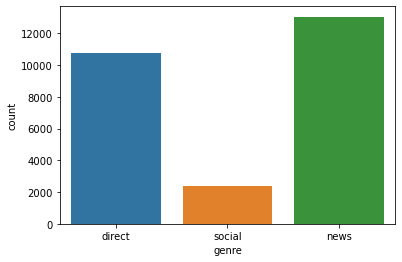

In [18]:
sns.countplot(df['genre']);

We can see that most of the messages are form the news (more than 12k). Messages sent directly are second in nimbers (about 11k) and social media comes third (around 2.5k)

Now, let's see distribution of labels in each class.

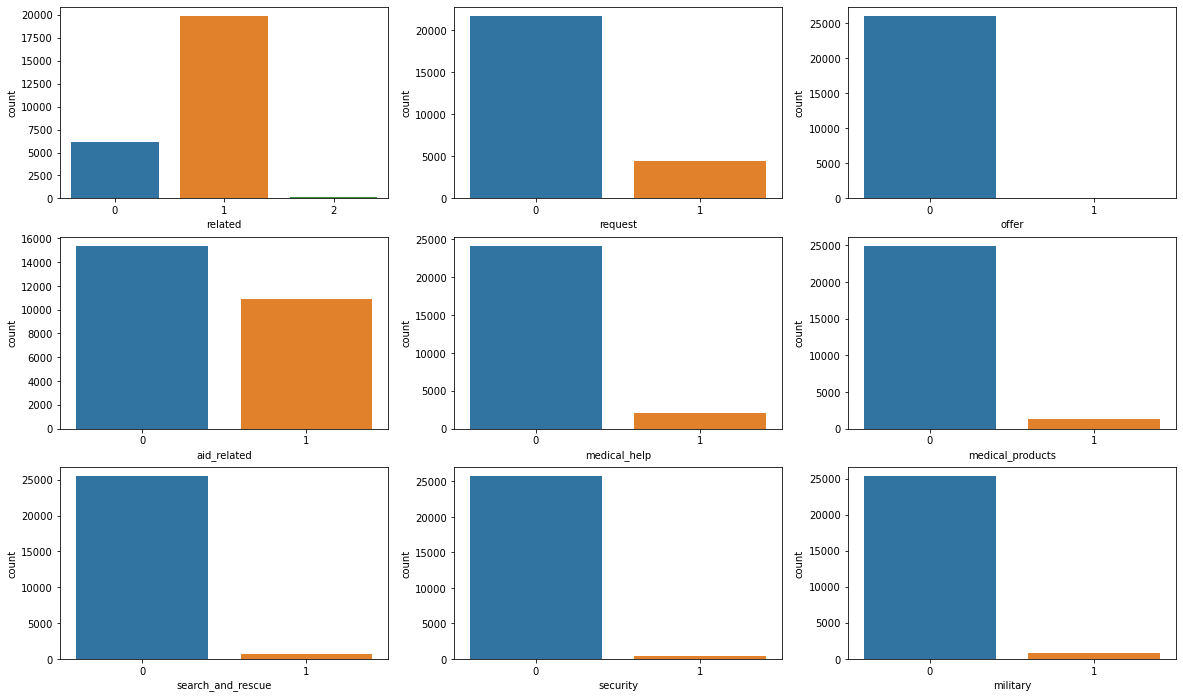

In [20]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(20,12))
for ax,col in zip(axes.flatten(),categories[:9]):
    sns.countplot(df[col], ax=ax);

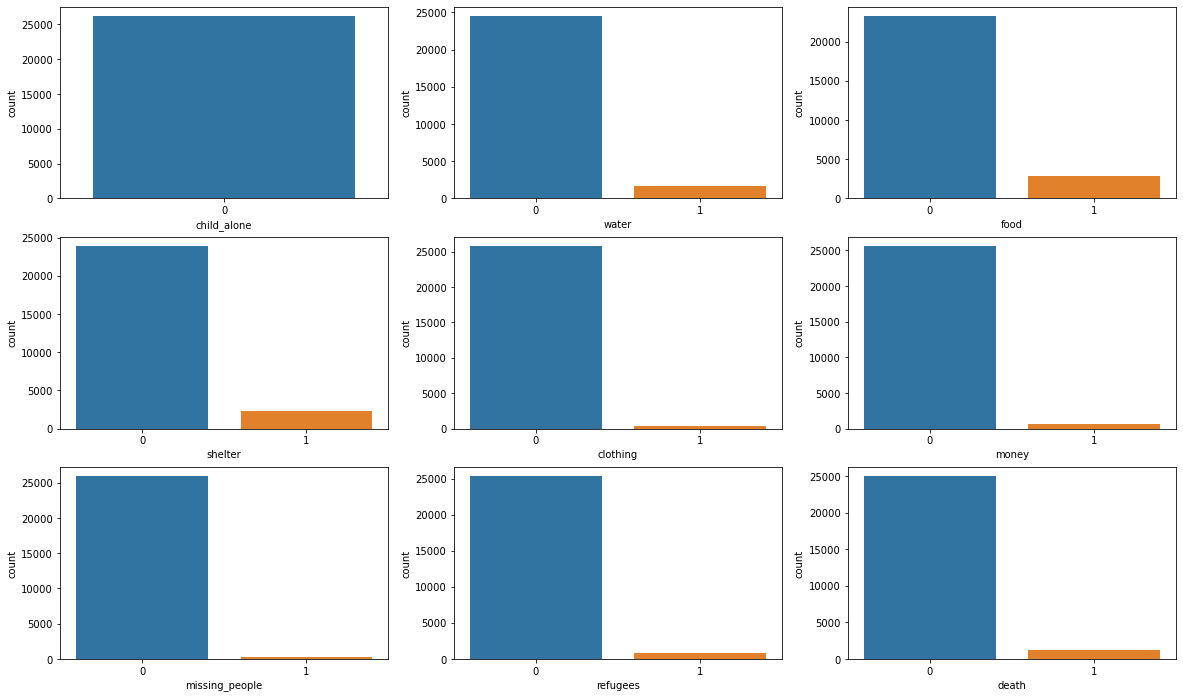

In [21]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(20,12))
for ax,col in zip(axes.flatten(),categories[9:18]):
    sns.countplot(df[col], ax=ax);

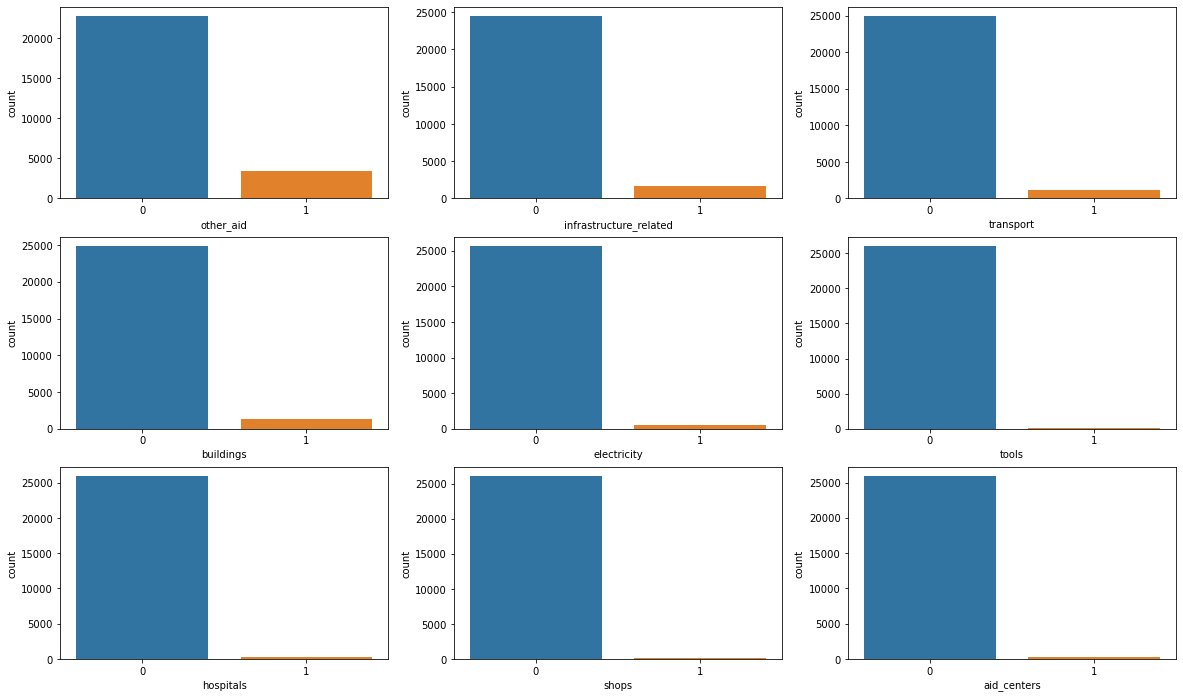

In [22]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(20,12))
for ax,col in zip(axes.flatten(),categories[18:27]):
    sns.countplot(df[col], ax=ax);

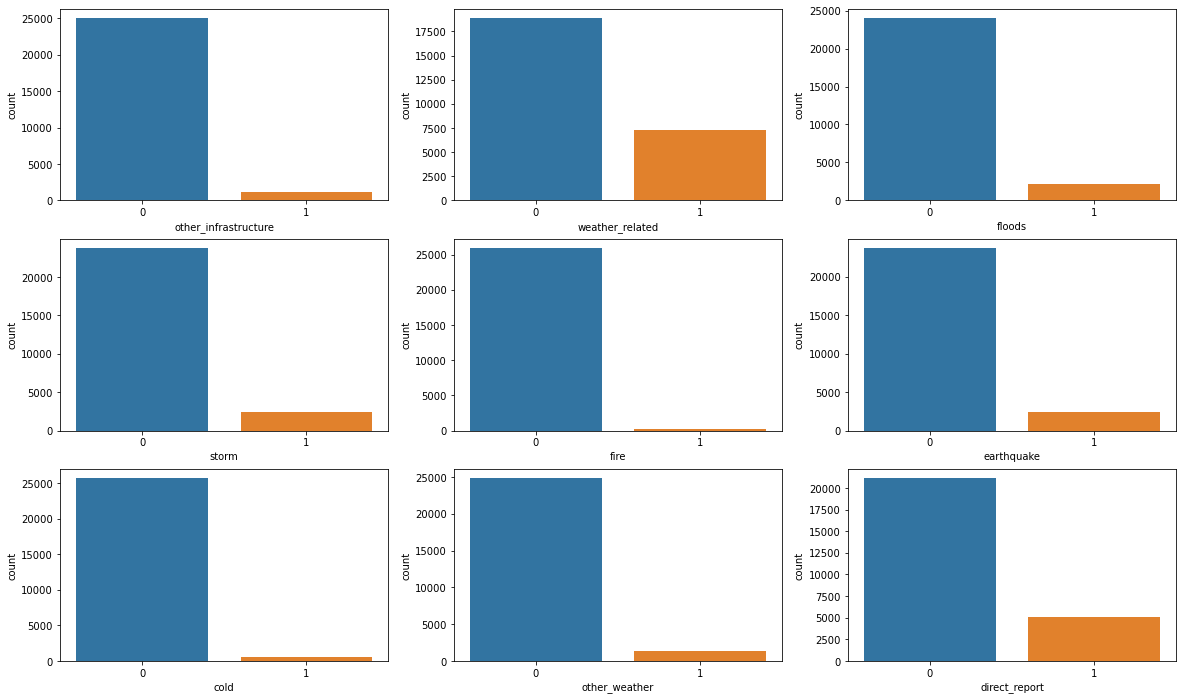

In [23]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(20,12))
for ax,col in zip(axes.flatten(),categories[27:]):
    sns.countplot(df[col], ax=ax);

Things to note after seeing the graphs above:
- all classes are highly imbalanced and we will have to choose metrics carefully while building a model in order to classifier work properly
- 'child_alone' class has only one label, so I'll drop that column for simplicity
- 'related' class is multi-label while others (except for 'child alone') are binary.

In [32]:
# copy of the dataset, just in case
df_copy = df.copy()

# drop 'child_alone' column
df.drop('child_alone', axis=1, inplace=True)

# also take it out from categories list
categories.remove('child_alone')

Let's have a closer look at 'related' column.

In [26]:
df['related'].value_counts()

1    19906
0     6122
2      188
Name: related, dtype: int64

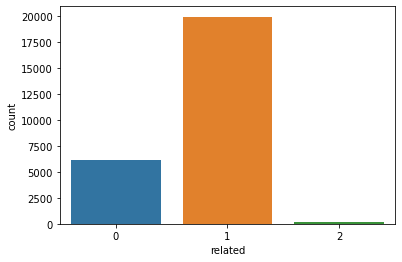

In [28]:
sns.countplot(df['related']);

So, label 1 is most represented (almost 20k messages), label 0 is second with around 6k and label 2 is the last with only 188 messages. As far as I understood, 1 means that the message is disaster related and then it's positively classified accordingly (e.g aid_related, military, refugees, etc.). 0 means message is irrelevant to our problem, therefore, it's negatively classified across all the classes. The question is what label 2 means and if it is somehow connected to labels 1 or 0. While researching the problem I found out that when the message has label 0 or label 2 in 'related' column, all other classes are classified as 0s as well.

In [57]:
# show that 0 and 2 labels in 'related' column are identical
print(f'Number of duplicated rows in categories when "related" column is either 0 or 2 is {df[df["related"] != 1][categories[1:]].duplicated().sum()} out of {len(df[df["related"] != 1][categories])}')

Number of duplicated rows in categories when "related" column is either 0 or 2 is 6309 out of 6310


So, as we can see all labels in all classes are duplicated if 'related' column labeled 0 or 2. This means we can safely put 0s instead 2s in 'related' column which will make all classes binary, hense, a tiny bit easier to classify.

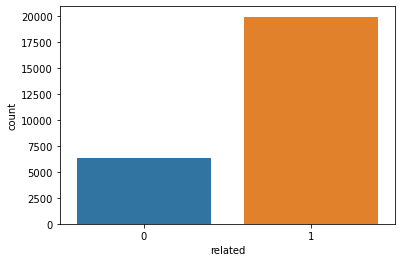

In [59]:
# put 0s instead of 2s in 'related' column
df['related'] = df['related'].map({0:0,1:1,2:0})

# see what we have now
sns.countplot(df['related']);

Now let's see number of messages ofr each class and how many of them belong to several classes at the same time.

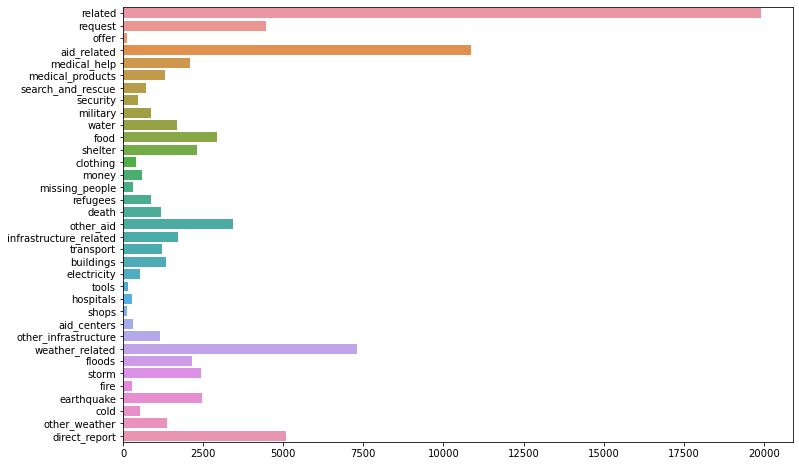

In [69]:
# number of message for each class (just sum up 0s and 1s across the columns)
plt.figure(figsize=(12,8))
sns.barplot(x=df.iloc[:,4:].sum().values, y=categories);

So, 'related', 'aid_related' and 'weather_related' are the most popoular classes.

And number of messages belonging to multiple classes at the same time.

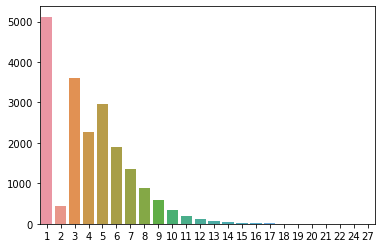

In [75]:
# just sum up 0s and 1s across the rows
multiclass = df.iloc[:,4:].sum(axis=1).value_counts()[1:]
plt.figure(figsize=(6,4))
sns.barplot(multiclass.index, multiclass.values);

Well, more than 5k messages belong to 1 class only but there are some that belong to several classes (2,3, up to 27 classes).

Now, I want to create additional column with number of words in each column (might use it while building the model) and see how those numbers are distributed. Before doing that I want to get rid of as many contractions as possible and transform them into full versions of words (only most popular).

In [76]:
# contractions dictionary to replace short versions with full versions
contractions_dict = {
  "i'm":"i am",
  "i'll":"i will",  
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "i'd": "I would",
  "i'd've": "I would have",
  "i'll": "I will",
  "i'll've": "I will have",
  "i'm": "I am",
  "i've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

# compile
c_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# function to expand contractions
def expand_contractions(message, c_re=c_re):
    
    """
    Expands contractions according to pre-compiled dictionary.
    message - string, text where contractions have to be expanded.
    """
    
    def replace(match):
        return contractions_dict[match.group(0)]
    
    return c_re.sub(replace, message)


# function to calculate number of words in the message
def word_count(message):
    """
    Counts the number of words in message.
    message - string, text to count the number of words in it.
    """
    return len(str(message).split(' '))

In [108]:
# copy the dataset
df_copy = df.copy()

In [111]:
# apply the functions
df['message'] = [message.lower() for message in df['message']] # only lower case contractions in pre-compiled dict
df['message'] = df['message'].apply(expand_contractions)
df['word_count'] = df['message'].apply(word_count)

# see what we've got
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,word_count
0,2,weather update - a cold front from cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13
1,7,is the hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,9
2,8,looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
3,9,un reports leogane 80-90 destroyed. only hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,13
4,12,"says: west side of haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12


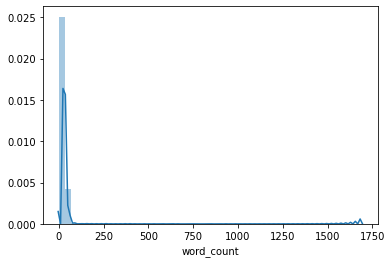

In [112]:
sns.distplot(df['word_count']);

So, majority of the messages are between 0 and about 50-100 words. But there also seem to be some message with more than 1600 words in them.

Also, I want to see some word clouds in order to have an idea of what are the key and most common words in the dataset in general and for each class.
First, let's see a general word cloud of all the words in 'message' column (stop words removed).

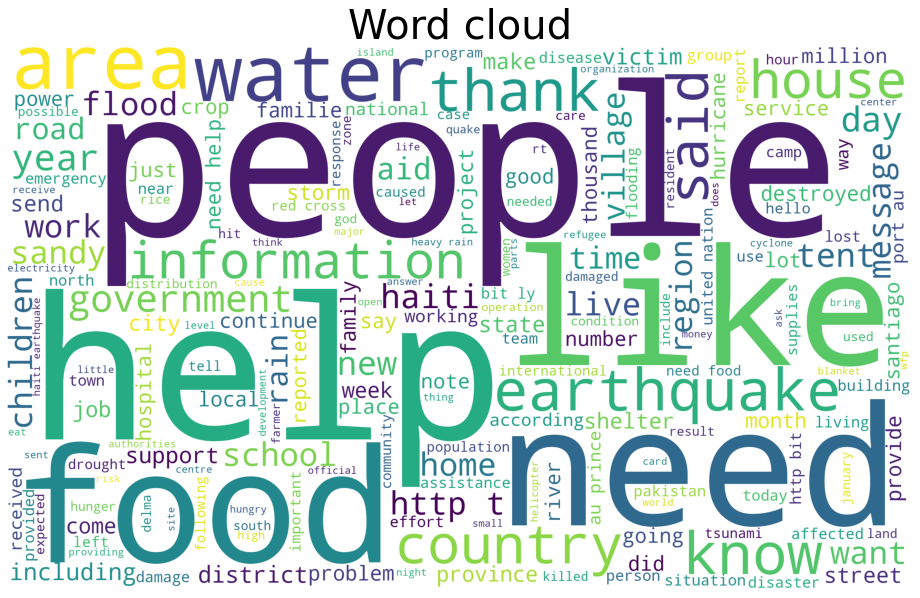

In [113]:
# creating a cloud
word_cloud = WordCloud(stopwords=ENGLISH_STOP_WORDS,
                      background_color='white', 
                      width=2500,
                      height=1500)

# generate a word cloud
word_cloud.generate(' '.join(df['message'].values))

# plot the word cloud
plt.figure(figsize=(25,10))
plt.axis('off')
plt.title('Word cloud', fontsize=40)
plt.imshow(word_cloud);

As expected, help, people, water, need, food are moest common words occuring in the dataset. One thing to notice is although we filtered stop words, some of them are still in the dataset. I don't think that words like 'bit','ly','http','au','thank' will add any useful information to our classifier, so we'll have to expand stop words vocabulary to filter them out. Also, there are same words in different forms (e.g. need and needed) that should be processed as well before building the classifier.
Now, let's have a look at some word clouds per classes.

In [114]:
# a function to plot a word cloud
def plot_cloud(df=df,colname='related',background_color='white'):
    """
    Creates, generates and plots a word cloud.
    df - dataframe of disaster messages and labeled classes
    colname - string, column name of the class in the dataset
    """
    
    word_cloud = WordCloud(stopwords=ENGLISH_STOP_WORDS,
                          background_color=background_color,
                          width=2500,
                          height=1500)
    
    word_cloud.generate(' '.join(df[df[colname]==1]['message'].values))
    
    plt.figure(figsize=(25,10))
    plt.axis('off')
    plt.title(f'{colname} class', fontsize=40)
    plt.imshow(word_cloud);
    
    return plt.show()

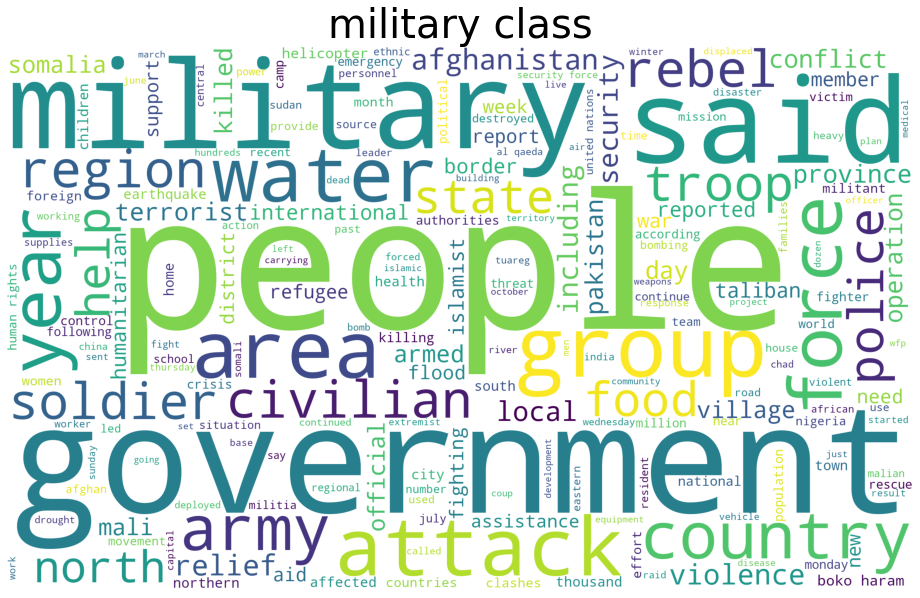

In [115]:
# military class
plot_cloud(colname='military')

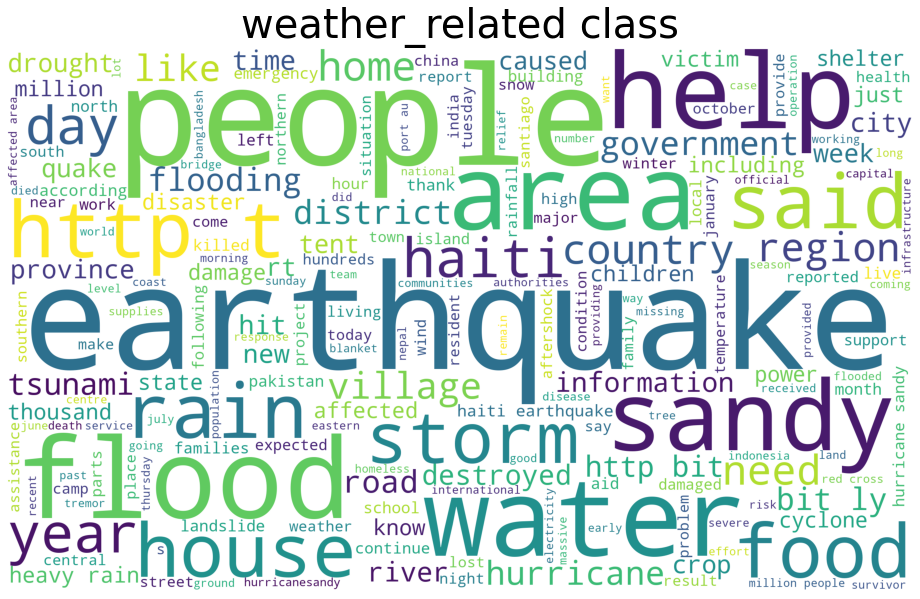

In [116]:
# wheather_related class
plot_cloud(colname='weather_related')

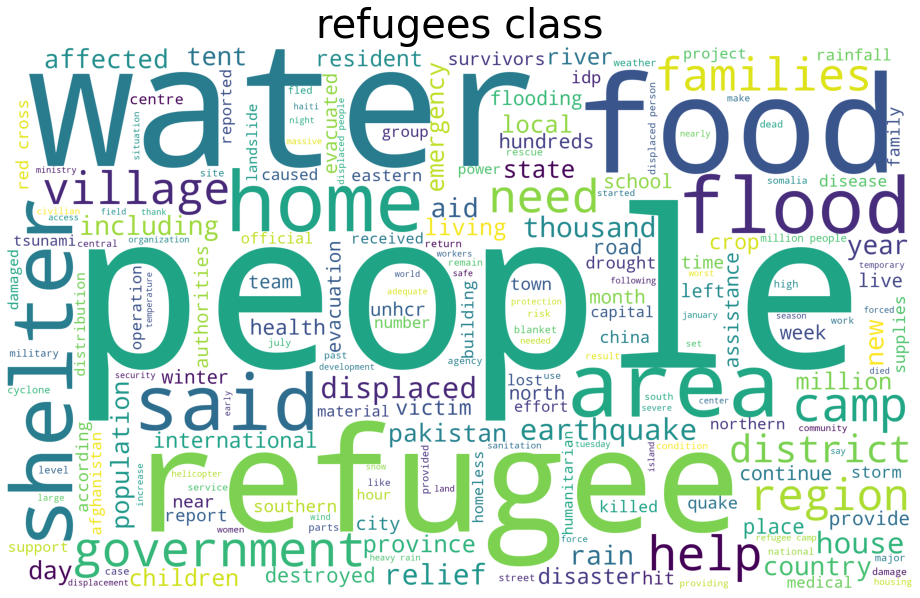

In [117]:
# refugees class
plot_cloud(colname='refugees')

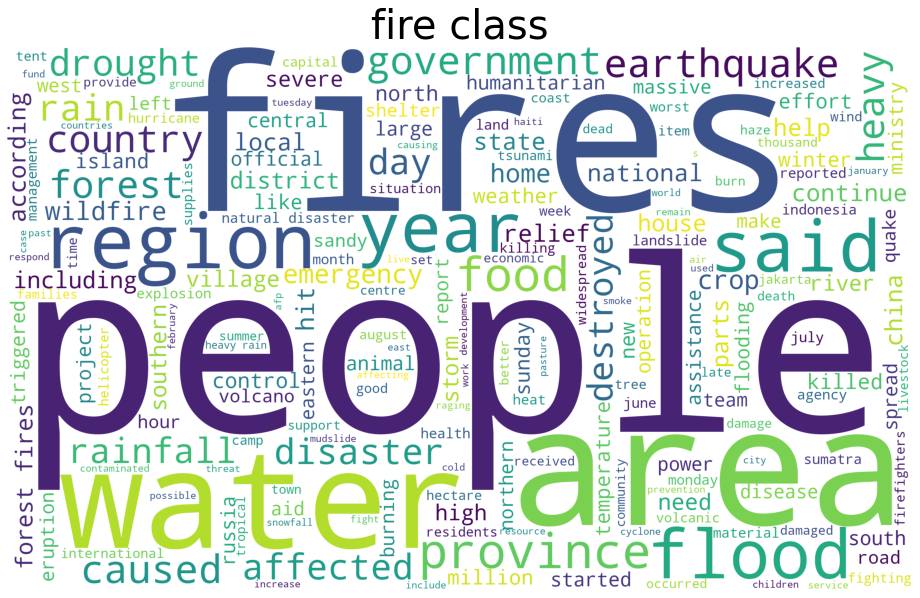

In [118]:
# fire class
plot_cloud(colname='fire')

As we can see, 'help','people','food' and 'water' are still some of the most popular words across different disaster classes. But there also differencies. For example, 'military','force','rebel','government' and 'attack' are among most popular words in military related disasters. 'Camp','shelter','refugee' are in refugees related class and 'fire','forest','drought' are in fire related disasters.

I believe it could be very informative to add those word clouds to the web app. E.g. a drop-out menu where you can pick a disaster class and see the word cloud.

OK, now let's have a look at most common bigrams in the dataset and in each class separately. To do that, we'll have to preprocess text first.

In [134]:
# function to preprocess text
def process_text(text):
    """
    Tokenizes, decontracts, lemmatizes text, removes all non-alphabetic characters and stop words.
    Returns processed text.
    text - string, text to process
    """
    
    # decontract
    text = expand_contractions(text.lower())
    
    # remove all non-alphabetic characters
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    
    # tokenize
    tokens = word_tokenize(text)
    
    # lemmatize and remove stop words
    tokens = [WordNetLemmatizer().lemmatize(token) for token in tokens if token not in ENGLISH_STOP_WORDS]
    
    return tokens


# function to find top bigrams
def bigram_freq(messages,top=10):
    
    """
    Returns a dataframe of top bigrams in text and their count.
    messages - Series of texts
    top - int, number of most frequent bigrams to return
    """
    
    messages = [process_text(message) for message in messages]
    
    # using gensim's Phrases to build bigrams model
    bigram_model = Phrases(messages, min_count=2, threshold=1)
    
    # list of possible bigrams
    possible_bigram = list(bigram_model[messages])
    
    # flatten the list
    flat_bigram = [item for sublist in possible_bigram for item in sublist]
    
    # list of bigrams
    bigrams = [bigram for bigram in flat_bigram if '_' in bigram]
    #bigrams = []
    #for bigram in flat_bigram:
        #if '_' in bigram:
            #bigrams.append(bigram)
    
    # count them and find most frequent
    top_bigrams = Counter(bigrams).most_common(top)
    
    # dataframe
    df_bigram = pd.DataFrame(data={'bigram':[bigram[0] for bigram in top_bigrams],
                                   'count':[bigram[1] for bigram in top_bigrams]})
    
    return df_bigram

Top 20 bigrams in the dataset.

In [136]:
bigram_freq(df['message'],top=20)

,bigram,count
0,http_t,412
1,like_know,410
2,need_help,330
3,united_nation,237
4,need_food,226
5,port_au,222
6,red_cross,192
7,http_bit,189
8,food_water,169
9,good_evening,167


Just like with word cloud, we can see that text would need a bit more preprocessing to get rid of useless words. I'll add them to stop words list in machine learning part. For now, let's see bigrams across some of the classes.

Top 20 in 'earthquake' class.

In [137]:
bigram_freq(df[df['earthquake']==1]['message'],20)

,bigram,count
0,http_bit,140
1,haiti_earthquake,134
2,bit_ly,86
3,earthquake_haiti,70
4,magnitude_earthquake,57
5,like_know,47
6,port_au,47
7,information_earthquake,47
8,like_information,37
9,victim_earthquake,30


Or top 20 bigrams in 'missing_people' class.

In [138]:
bigram_freq(df[df['missing_people']==1]['message'],20)

,bigram,count
0,dead_missing,11
1,official_said,11
2,http_bit,9
3,port_au,8
4,killed_people,8
5,people_died,8
6,heavy_rain,8
7,death_toll,7
8,need_help,6
9,earthquake_haiti,6


Alright, to conclude this section, I want to write down steps for ETL pipeline. The pipeline will:
- read data from two .csv files (messages.csv and categories.csv) and merge them into one dataframe
- create a new column for each disaster class and populate it
- drop duplicates
- save the dataframe as a table in database

ETL script can be found in process_data.py file.